In [1]:
# --- 1. SETUP AND IMPORTS ---
# Member 2: Implementation of a Deep Residual Network (ResNet-like DNN) for Tabular Data
# This model uses the Keras Functional API to implement stable skip connections.

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Suppress the FutureWarnings related to pandas downcasting for clean output
warnings.filterwarnings("ignore", category=FutureWarning) 

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries loaded successfully. Using Keras Functional API.")

Libraries loaded successfully. Using Keras Functional API.


In [2]:
# --- 2. DATA LOADING AND INITIAL CLEANING ---

try:
    data = pd.read_csv('Cancer_Data.csv') # [1]
    
    # Check for the common redundant column (if present)
    if 'Unnamed: 32' in data.columns:
        data = data.drop(['Unnamed: 32'], axis=1) 
        
    print(f"Dataset shape: {data.shape}")
except FileNotFoundError:
    print("Error: 'Cancer_Data.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Identify Features (X) and Target (Y)
X = data.drop(['id', 'diagnosis'], axis=1) # [1]
Y = data['diagnosis']


Dataset shape: (569, 32)


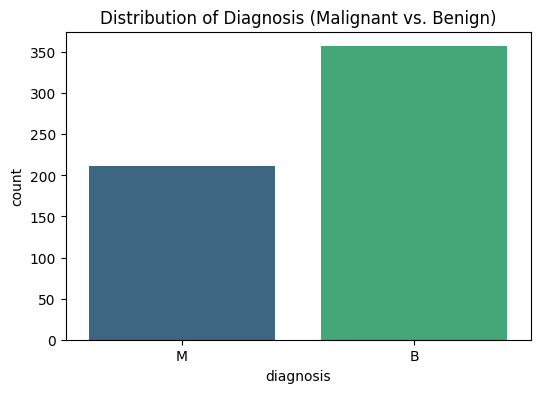

In [3]:
# --- 3. EXPLORATORY DATA ANALYSIS (EDA) AND VISUALIZATIONS (REPLICATED FROM M1) ---

# 3.1. Target Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=data, palette='viridis')
plt.title('Distribution of Diagnosis (Malignant vs. Benign)')
plt.show()

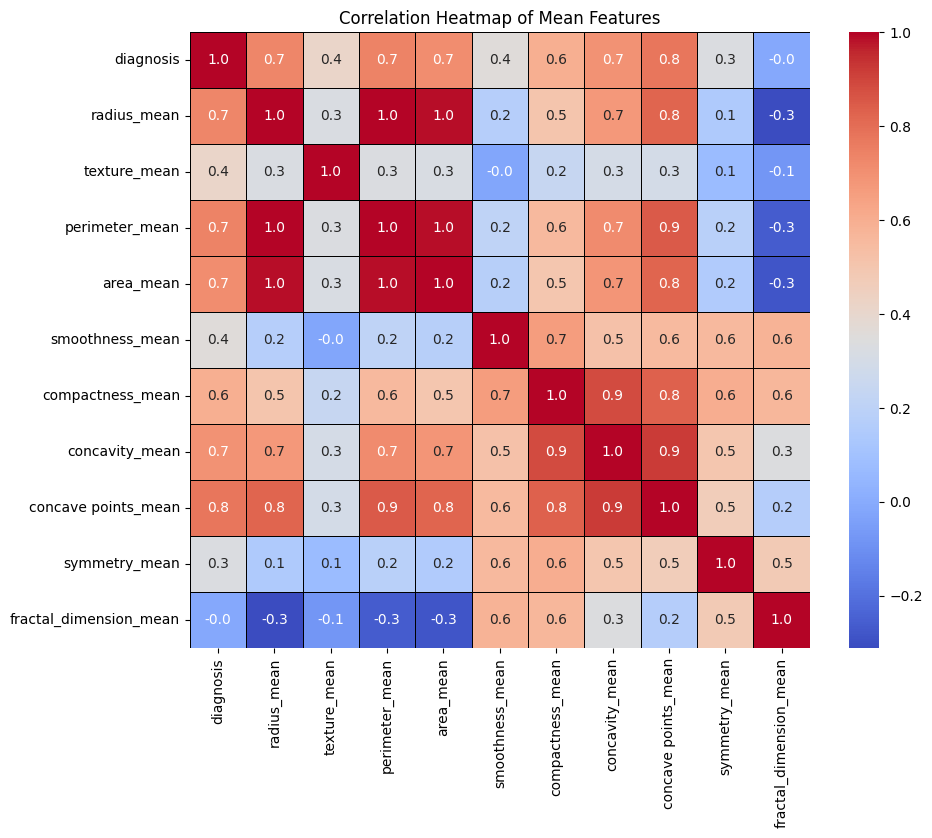

In [4]:
# 3.2. Feature Correlation Heatmap (using mean features)
data_corr = data.copy()
# Encode diagnosis temporarily for correlation calculation (1/0)
data_corr['diagnosis'] = data_corr['diagnosis'].replace({'M': 1, 'B': 0}).astype(int) 
mean_features = ['diagnosis'] + [col for col in data_corr.columns if 'mean' in col]
corr_matrix = data_corr[mean_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', 
            linewidths=.5, linecolor='black')
plt.title('Correlation Heatmap of Mean Features')
plt.show()

In [5]:
# --- 4. DATA PREPARATION (SPLIT FIRST) ---

# 4.1. Target Encoding 
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y) # 'M' -> 1, 'B' -> 0

TEST_SIZE_FINAL = 0.15 
VAL_SIZE_RATIO = 0.1764 # (~15% of total samples for validation)

# Split 1: Training Pool (85%) and Test Set (15%), stratified
X_train_full, X_test, Y_train_full, Y_test = train_test_split(
    X.values, encoded_Y, test_size=TEST_SIZE_FINAL, random_state=42, stratify=encoded_Y
)

# Split 2: Training Set (70%) and Validation Set (15%)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_full, Y_train_full, test_size=VAL_SIZE_RATIO, random_state=42, stratify=Y_train_full
)

In [6]:
# --- 5. DATA PREPROCESSING (SCALE AFTER SPLIT) (10% Grading Weight) ---

scaler = StandardScaler()

# 5.1. Fit ONLY on Training Data (Essential to prevent data leakage)
X_train_scaled = scaler.fit_transform(X_train) 

# 5.2. Transform Validation and Test Data using Training Data's statistics
X_val_scaled = scaler.transform(X_val)       
X_test_scaled = scaler.transform(X_test)     

input_dim = X_train_scaled.shape[1]

print(f"\nData successfully split and scaled.")



Data successfully split and scaled.


In [9]:
# --- 6. CUSTOM RESIDUAL BLOCK DEFINITION (CORE MEMBER 2 CONTRIBUTION) ---

def dense_residual_block(x, units, dropout_rate=0.2, name="ResBlock"):
    """
    Implements a Dense Residual Block: H(x) = F(x) + x_skip
    Utilizes the Keras Functional API for skip connections.
    """
    x_skip = x # Store the input for the shortcut path
    
    # Check and handle Skip Connection Dimension Mismatch
    # If the input tensor dimension does not match the desired output units, project the skip path (1x1 conv analogue)
    if x_skip.shape[-1]!= units:
        x_skip = Dense(units, activation=None, name=f"{name}_ProjSkip")(x_skip)
        x_skip = BatchNormalization(name=f"{name}_ProjSkipBN")(x_skip)
        
    # 1. Residual Pathway (F(x))
    # Path 1: Dense -> BN -> ReLU -> Dropout
    fx = Dense(units, activation='relu', name=f"{name}_Dense1")(x)
    fx = BatchNormalization(name=f"{name}_BN1")(fx)
    fx = Dropout(dropout_rate, name=f"{name}_Dropout1")(fx)

    # Path 2: Dense -> BN (Linear layer before addition, final non-linearity applied after add)
    fx = Dense(units, activation=None, name=f"{name}_Dense2")(fx)
    fx = BatchNormalization(name=f"{name}_BN2")(fx)
    
    # 2. Skip Connection (Addition)
    # Add the residual output (fx) to the identity skip connection (x_skip)
    out = Add(name=f"{name}_Add")([x_skip, fx]) # [2]
    
    # 3. Final Activation
    out = Activation('relu', name=f"{name}_FinalActivation")(out)
    return out

In [8]:
# 1. Residual Pathway (F(x))
    # Path 1: Dense -> BN -> ReLU -> Dropout
    fx = Dense(units, activation='relu', name=f"{name}_Dense1")(x)
    fx = BatchNormalization(name=f"{name}_BN1")(fx)
    fx = Dropout(dropout_rate, name=f"{name}_Dropout1")(fx)

    # Path 2: Dense -> BN (Linear layer before addition, final non-linearity applied after add)
    fx = Dense(units, activation=None, name=f"{name}_Dense2")(fx)
    fx = BatchNormalization(name=f"{name}_BN2")(fx)
    
    # 2. Skip Connection (Addition)
    # Add the residual output (fx) to the identity skip connection (x_skip)
    out = Add(name=f"{name}_Add")([x_skip, fx]) # [2]
    
    # 3. Final Activation
    out = Activation('relu', name=f"{name}_FinalActivation")(out)
    return out

IndentationError: unexpected indent (3523844465.py, line 3)

In [11]:
def residual_block(x, x_skip, units, dropout_rate, name):
    # 1. Residual Pathway (F(x))
    # Path 1: Dense -> BN -> ReLU -> Dropout
    fx = Dense(units, activation='relu', name=f"{name}_Dense1")(x)
    fx = BatchNormalization(name=f"{name}_BN1")(fx)
    fx = Dropout(dropout_rate, name=f"{name}_Dropout1")(fx)
    
    # Rest of the code...
    
    return out

In [12]:
# --- 7. MODEL ARCHITECTURE DEFINITION (Stacking Blocks) ---

def create_resnet_dnn(input_dim):
    inputs = Input(shape=(input_dim,), name="Input_Features")
    
    # Initial Feature Projection Layer
    x = Dense(128, activation='relu', name="Initial_Dense")(inputs)
    x = BatchNormalization(name="Initial_BN")(x)
    
    # Stacked Residual Blocks (Creating a much deeper, more stable network)
    x = dense_residual_block(x, units=128, name="Block_A", dropout_rate=0.3)
    x = dense_residual_block(x, units=64, name="Block_B", dropout_rate=0.3) # Units changed, projection used
    x = dense_residual_block(x, units=64, name="Block_C", dropout_rate=0.3) 
    x = dense_residual_block(x, units=32, name="Block_D", dropout_rate=0.3) # Units changed, projection used
    
    # Final Classification Head
    outputs = Dense(1, activation='sigmoid', name="Output_Classification")(x) # Sigmoid for binary classification
    
    model = Model(inputs=inputs, outputs=outputs, name="ResNet_DNN_M2")
    return model

model_m2 = create_resnet_dnn(input_dim)
print("\nModel Architecture (ResNet-DNN - Deep and Stable):")
model_m2.summary()


Model Architecture (ResNet-DNN - Deep and Stable):


Model: "ResNet_DNN_M2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Features (InputLayer)   │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Initial_Dense (Dense)         │ (None, 128)               │           3,968 │ Input_Features[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Initial_BN                    │ (None, 128)               │             512 │ Initial_Dense[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_A_Dense1 (Dense)        │ (None, 128)               │          16,512 │ Initial_BN[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_A_BN1                   │ (None, 128)               │             512 │ Block_A_Dense1[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_A_Dropout1 (Dropout)    │ (None, 128)               │               0 │ Block_A_BN1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_A_Dense2 (Dense)        │ (None, 128)               │          16,512 │ Block_A_Dropout1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_A_BN2                   │ (None, 128)               │             512 │ Block_A_Dense2[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_A_Add (Add)             │ (None, 128)               │               0 │ Initial_BN[0][0],          │
│                               │                           │                 │ Block_A_BN2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_A_FinalActivation       │ (None, 128)               │               0 │ Block_A_Add[0][0]          │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_B_Dense1 (Dense)        │ (None, 64)                │           8,256 │ Block_A_FinalActivation[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_B_BN1                   │ (None, 64)                │             256 │ Block_B_Dense1[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_B_Dropout1 (Dropout)    │ (None, 64)                │               0 │ Block_B_BN1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Block_B_ProjSkip (Dense)      │ (None, 64)                │           8,256 │ Block_A_FinalActivation[0… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 74,433 (290.75 KB)

 Trainable params: 72,833 (284.50 KB)

 Non-trainable params: 1,600 (6.25 KB)

In [13]:
# --- 8. MODEL COMPILATION AND TRAINING ---

model_m2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=['accuracy', keras.metrics.AUC(name='auc')] # AUC is critical for medical comparison
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,          
    restore_best_weights=True # [3]
)

print("\nStarting Model Training...")
history_m2 = model_m2.fit(
    X_train_scaled, Y_train,
    epochs=300,             
    batch_size=32,
    validation_data=(X_val_scaled, Y_val),
    callbacks=[early_stopping],
    verbose=2
)
print("Model training finished.")



Starting Model Training...
Epoch 1/300
13/13 - 26s - 2s/step - accuracy: 0.7103 - auc: 0.7460 - loss: 0.5684 - val_accuracy: 0.9186 - val_auc: 0.9780 - val_loss: 0.4400
Epoch 2/300
13/13 - 1s - 49ms/step - accuracy: 0.8615 - auc: 0.9260 - loss: 0.3488 - val_accuracy: 0.9186 - val_auc: 0.9884 - val_loss: 0.3526
Epoch 3/300
13/13 - 1s - 53ms/step - accuracy: 0.9093 - auc: 0.9618 - loss: 0.2562 - val_accuracy: 0.9419 - val_auc: 0.9916 - val_loss: 0.3011
Epoch 4/300
13/13 - 1s - 51ms/step - accuracy: 0.9320 - auc: 0.9743 - loss: 0.2165 - val_accuracy: 0.9419 - val_auc: 0.9957 - val_loss: 0.2491
Epoch 5/300
13/13 - 1s - 49ms/step - accuracy: 0.9521 - auc: 0.9821 - loss: 0.1704 - val_accuracy: 0.9419 - val_auc: 0.9965 - val_loss: 0.2165
Epoch 6/300
13/13 - 1s - 50ms/step - accuracy: 0.9622 - auc: 0.9881 - loss: 0.1435 - val_accuracy: 0.9419 - val_auc: 0.9977 - val_loss: 0.1876
Epoch 7/300
13/13 - 1s - 50ms/step - accuracy: 0.9521 - auc: 0.9903 - loss: 0.1373 - val_accuracy: 0.9419 - val_auc

In [14]:
# --- 9. MODEL EVALUATION (5% Grading Weight) ---

print("\nEvaluating Model on the held-out Test Set (15%):")
loss_m2, accuracy_m2, auc_m2 = model_m2.evaluate(X_test_scaled, Y_test, verbose=0)

print(f"\n--- Member 2 (ResNet-DNN) Final Test Results ---")
print(f"Test Loss: {loss_m2:.4f}")
print(f"Test Accuracy: {accuracy_m2:.4f}")
print(f"Test AUC-ROC: {auc_m2:.4f}")

# Generate detailed classification report
Y_pred_prob = model_m2.predict(X_test_scaled)
Y_pred_class = (Y_pred_prob > 0.5).astype("int32")

report = classification_report(Y_test, Y_pred_class, target_names=encoder.classes_)
print("\nClassification Report (Key Metrics for Comparison):")
print(report)


Evaluating Model on the held-out Test Set (15%):

--- Member 2 (ResNet-DNN) Final Test Results ---
Test Loss: 0.0634
Test Accuracy: 0.9651
Test AUC-ROC: 0.9988
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step

Classification Report (Key Metrics for Comparison):
              precision    recall  f1-score   support

           B       0.96      0.98      0.97        54
           M       0.97      0.94      0.95        32

    accuracy                           0.97        86
   macro avg       0.97      0.96      0.96        86
weighted avg       0.97      0.97      0.96        86

